# 東京の感染者数

データは  
https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv  
を使わせていただく。  
まず、データフレームに格納。その際に「公表_年月日」のカラムを日付として解釈しておく。

In [179]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv', 
                 parse_dates=['公表_年月日'])

df.head()

,No,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,曜日,発症_年月日,患者_居住地,患者_年代,患者_性別,患者_属性,患者_状態,患者_症状,患者_渡航歴の有無フラグ,備考,退院済フラグ
0,1,130001,東京都,NaN,2020-01-24,金,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,1.0
1,2,130001,東京都,NaN,2020-01-25,土,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
2,3,130001,東京都,NaN,2020-01-30,木,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
3,4,130001,東京都,NaN,2020-02-13,木,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,1.0
4,5,130001,東京都,NaN,2020-02-14,金,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,1.0


## 日付ごとの集計
データフレームの日付の出現を数えて、日毎の感染者数とする。同時に累積の感染者数も計算しておく。

In [180]:
date = []
daily_case = []
total_case = []
current_accum_case = 0
for k, v in df["公表_年月日"].value_counts().sort_index().items():
    date.append(k)
    daily_case.append(v)
    current_accum_case += v
    total_case.append(current_accum_case)

日毎の感染者数と累積の感染者数をカラムにもつデータフレームを作成。

In [181]:
df_daily = pd.DataFrame(
    {"daily_case": daily_case,
     "total_case": total_case},
    index = date
)
df_daily.head()

,daily_case,total_case
2020-01-24,1,1
2020-01-25,1,2
2020-01-30,1,3
2020-02-13,1,4
2020-02-14,2,6


感染者が発見されていない日のデータが存在しないので、そのような日の行を含むデータフレームにしておく。

In [182]:
df_daily =df_daily.resample("1D").asfreq()
df_daily.head()

,daily_case,total_case
2020-01-24,1.0,1.0
2020-01-25,1.0,2.0
2020-01-26,NaN,NaN
2020-01-27,NaN,NaN
2020-01-28,NaN,NaN


追加された行のデータが存在しないので、NaNとなっている。新規感染者のNaNは0に、累積のNaNは一つ上の行と同じとしておく。

In [183]:
df_daily["daily_case"].fillna(0, inplace=True)
df_daily["total_case"].ffill(inplace=True)
df_daily.head()

,daily_case,total_case
2020-01-24,1.0,1.0
2020-01-25,1.0,2.0
2020-01-26,0.0,2.0
2020-01-27,0.0,2.0
2020-01-28,0.0,2.0


In [184]:
df["曜日"].value_counts()

金    1227
土    1085
木    1016
日     885
火     854
水     817
月     639
Name: 曜日, dtype: int64

報告数は月火水は少なくなる傾向があるようなので、7日間の移動平均を格納しておく。



In [185]:
df_daily["7day_MA"] = df_daily.rolling(7).mean()["daily_case"]
df_daily.tail()

,daily_case,total_case,7day_MA
2020-06-29,58.0,6171.0,51.857143
2020-06-30,54.0,6225.0,55.142857
2020-07-01,67.0,6292.0,56.857143
2020-07-02,107.0,6399.0,65.285714
2020-07-03,124.0,6523.0,75.285714


## 日毎の感染者数のプロット

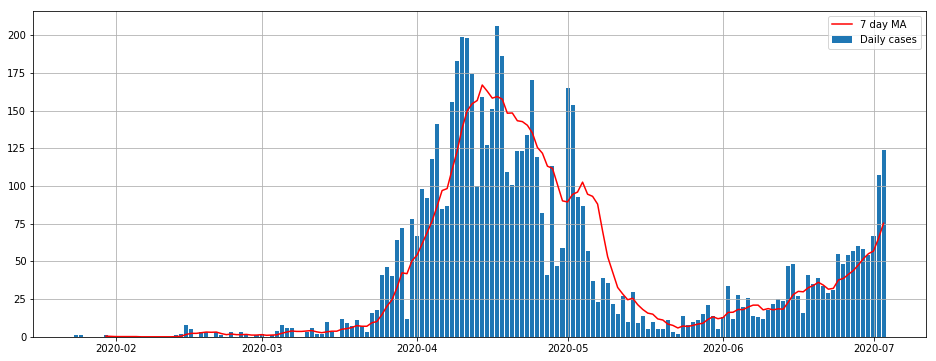

In [186]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax.bar(df_daily.index, df_daily["daily_case"], label="Daily cases")
ax.plot(df_daily.index, df_daily["7day_MA"], color="red", label="7 day MA")
ax.legend()
ax.grid()

plt.show()

## 日毎の感染者数のプロット（対数）

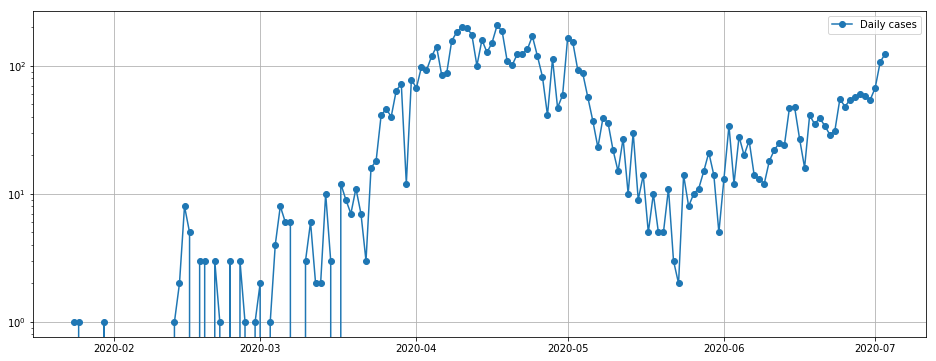

In [187]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax.plot(df_daily.index, df_daily["daily_case"], label="Daily cases", marker='o')
ax.set_yscale('log')
ax.legend()
ax.grid()

plt.show()

## 2020年5月25日以降の報告件数（対数）


                            OLS Regression Results                            
Dep. Variable:             daily_case   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     110.8
Date:                Sat, 04 Jul 2020   Prob (F-statistic):           8.04e-13
Time:                        00:44:33   Log-Likelihood:                -15.727
No. Observations:                  40   AIC:                             35.45
Df Residuals:                      38   BIC:                             38.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2611      0.114     19.804      0.0

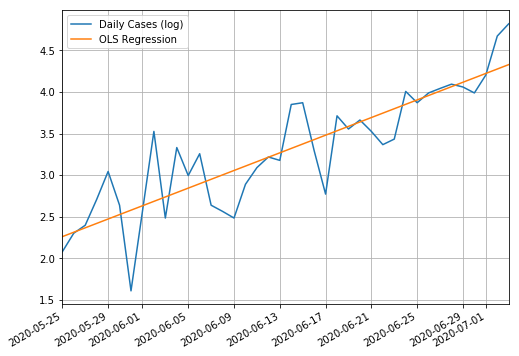

In [188]:
import statsmodels.api as sm

after_lifting = df_daily["2020-05-25":]

y = np.log(after_lifting["daily_case"])
x = range(len(y))
x = sm.add_constant(x)

model = sm.OLS(y,x)
result = model.fit()
print(result.summary())
fig = plt.figure(figsize=(8.0, 6.0))
ax = fig.add_subplot(111)
ax.plot(y, label="Daily Cases (log)")
result.fittedvalues.plot(label="OLS Regression")

ax.legend()
ax.grid()

plt.show()

## 累積の感染者数のプロット

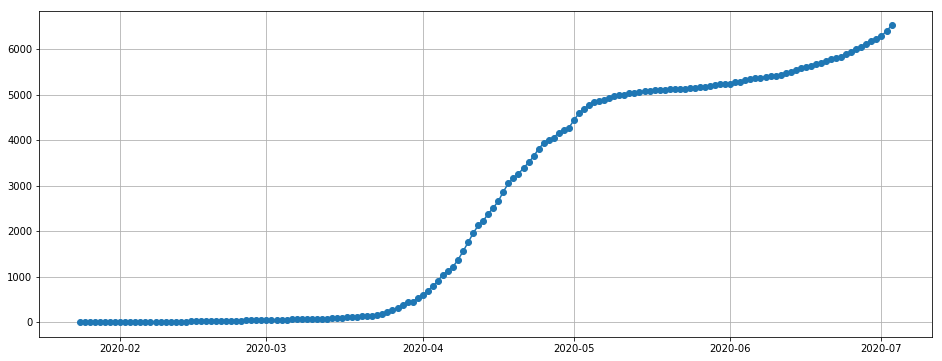

In [189]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
plt.plot(df_daily.index, df_daily["total_case"],marker='o')
ax.grid()

plt.show()

## 累積の感染者数のプロット（対数軸）

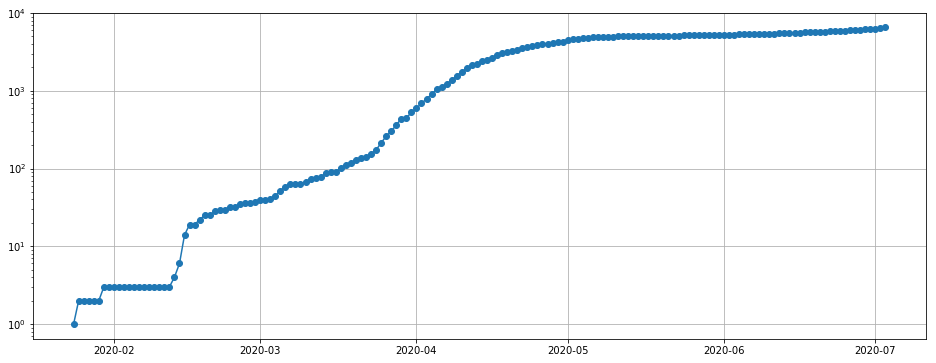

In [190]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax.set_yscale('log')
plt.plot(df_daily.index, df_daily["total_case"],marker='o')
ax.grid()

plt.show()

## 日毎の新規報告数（年代別積み上げ棒グラフ）

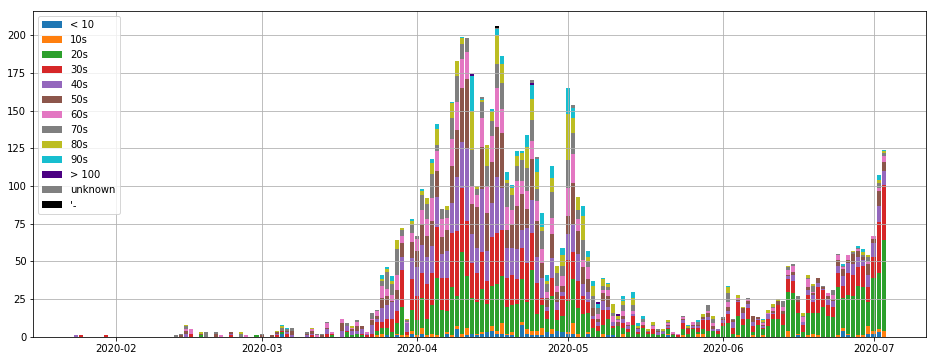

In [191]:

by_date_age = df.groupby(["公表_年月日","患者_年代"])
agg_count = by_date_age.size().unstack().fillna(0)

fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)

bottom = 0
p00 = plt.bar(agg_count.index,agg_count["10歳未満"], bottom=bottom)
bottom += agg_count["10歳未満"]
p01 = plt.bar(agg_count.index,agg_count["10代"], bottom=bottom)
bottom += agg_count["10代"]
p02 = plt.bar(agg_count.index,agg_count["20代"], bottom=bottom)
bottom += agg_count["20代"]
p03 = plt.bar(agg_count.index,agg_count["30代"], bottom=bottom)
bottom += agg_count["30代"]
p04 = plt.bar(agg_count.index,agg_count["40代"], bottom=bottom)
bottom += agg_count["40代"]
p05 = plt.bar(agg_count.index,agg_count["50代"], bottom=bottom)
bottom += agg_count["50代"]
p06 = plt.bar(agg_count.index,agg_count["60代"], bottom=bottom)
bottom += agg_count["60代"]
p07 = plt.bar(agg_count.index,agg_count["70代"], bottom=bottom)
bottom += agg_count["70代"]
p08 = plt.bar(agg_count.index,agg_count["80代"], bottom=bottom)
bottom += agg_count["80代"]
p09 = plt.bar(agg_count.index,agg_count["90代"], bottom=bottom)
bottom += agg_count["90代"]
p10 = plt.bar(agg_count.index,agg_count["100歳以上"], bottom=bottom, color="indigo")
bottom += agg_count["100歳以上"]
p_unknown = plt.bar(agg_count.index,agg_count["不明"], bottom=bottom, color="gray")
bottom += agg_count["不明"]
p_dash = plt.bar(agg_count.index,agg_count["'-"], bottom=bottom, color="black")


plt.legend(
    (p00[0], p01[0], p02[0], p03[0],p04[0], p05[0], p06[0], p07[0], p08[0], p09[0], p10[0], p_unknown[0], p_dash[0]), 
    ('< 10', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '> 100', 'unknown', "'-"))

ax.grid()
plt.show()


In [192]:
age_order = [
    "10歳未満", "10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代", "90代", "100歳以上", "不明", "'-"
]

pd.DataFrame(agg_count, columns = age_order).tail()


,10歳未満,10代,20代,30代,40代,50代,60代,70代,80代,90代,100歳以上,不明,'-
公表_年月日,,,,,,,,,,,,,
2020-06-29,0.0,1.0,32.0,14.0,4.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0
2020-06-30,2.0,5.0,16.0,10.0,8.0,7.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0
2020-07-01,2.0,2.0,35.0,14.0,9.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-02,3.0,2.0,37.0,34.0,11.0,10.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0
2020-07-03,0.0,4.0,60.0,37.0,9.0,6.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0


# K値の推移をプロットする

K値については  
「K値を政策として用いることの問題点」参照：  
https://note.com/kvalue/n/n64e553bb8c1b

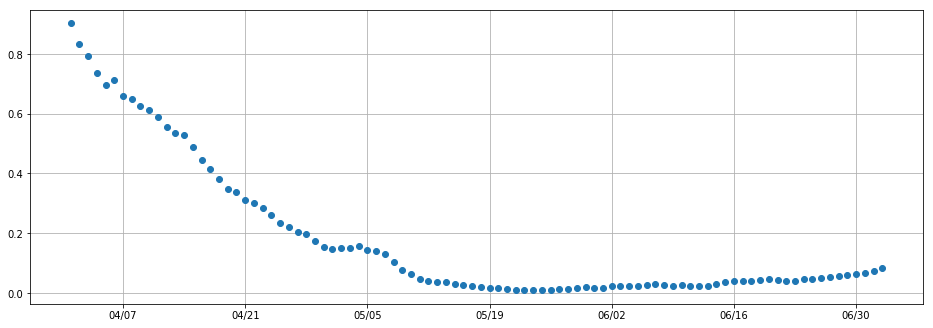

             K_value
2020-04-01  0.902381
2020-04-02  0.832046
2020-04-03  0.791803
2020-04-04  0.737637
2020-04-05  0.697353
             K_value
2020-06-29  0.060520
2020-06-30  0.063781
2020-07-01  0.065043
2020-07-02  0.073402
2020-07-03  0.082992


In [193]:
import datetime
import matplotlib.dates as mdates

def calc_k_value(df, date):
    today = date
    one_week_ago = today - datetime.timedelta(days=7)
    
    total_as_of_today = df.loc[today]
    total_as_of_one_week_ago = df.loc[one_week_ago]
    
    return 1 - (total_as_of_one_week_ago/total_as_of_today)

def plot_k_value(df, start_date):
    last_date = df.index.max()
    offset_date = start_date - datetime.timedelta(days=8)
    offset = df.loc[offset_date]["total_case"]
    offset_cases = (df["total_case"] - offset)
    
    index = pd.date_range(start_date, last_date, freq='D')
    k_values = [calc_k_value(offset_cases, i) for i in index]

    df_k = pd.DataFrame({"K_value": k_values}, index=index)
 
    fig = plt.figure(figsize=(16.0, 6.0))
    ax = fig.add_subplot(111)
    
    days    = mdates.DayLocator(bymonthday=None, interval=14) 
    daysFmt = mdates.DateFormatter('%m/%d') 
    ax.xaxis.set_major_locator(days) 
    ax.xaxis.set_major_formatter(daysFmt) 
    fig.autofmt_xdate() 
    ax.grid()

    plt.plot(df_k.index, df_k["K_value"], marker='o', linestyle="None")

    plt.show()
    print(df_k.head())
    print(df_k.tail())

plot_k_value(df_daily, datetime.date(2020, 4, 1))

In [194]:
df["患者_年代"].unique()

array(['40代', '30代', '70代', '50代', '60代', '80代', '20代', '10歳未満', '90代',
       '10代', '100歳以上', '不明', "'-"], dtype=object)